## CloudDBH

Running on data from Calders et al.

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import gc
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from descartes import PolygonPatch


# Functions

In [27]:
# Functions from Calders et al
# nearest neighbour needed for outlier removal
def nn(x,rad):
    """
    Function from TLS_Inventory.
    
    x: a numpy array, rad: radius to search for neighbors within
    
    My understanding - can either specify number of neighbors to return (in sklearn NearestNeighbors),
    or return all the neighbors and then filter to return only those within a specified distance radius
    """
    nbrs = NearestNeighbors(algorithm='auto', metric='euclidean').fit(x) 
    distances, indices = nbrs.radius_neighbors(radius=rad) #find all neighbours within this search radius
    
    #output explained: https://stackoverflow.com/questions/53886289/confused-with-the-output-of-sklearn-neighbors-nearestneighbors 
    return distances, indices


def load_pts(cloud,downsample=False,outliers=False): 
    """
    Function from TLS_Inventory that reads the point cloud data for single tree at a time and
    returns pandas dataframe with the points split into x, y, z coordinates. 
    
    cloud: point cloud from a single tree - note, point cloud data should be pre-processed and 
           split into individual trees prior to using this function.
    downsample (Optional): Default is False, meaning all the points are retained. If 
                           True, the point clouds are sampled to keep only fraction of points.
    outliers (Optional): Default is False, meaning outliers are retained. If True, 
    """
    # read the point cloud data for single tree and save as pandas df with columns for x, y, z coords
    dftemp=o3d.io.read_point_cloud(cloud)
    df=pd.DataFrame(data=np.asarray(dftemp.points),columns=['x', 'y', 'z']) #access the points
    
    # Optional downsampling
    if downsample:
        df=df.sample(frac=0.1) # keep 10pct of points
    
    # Optional outlier removal 
    if outliers: #remove outliers
        xy=df.iloc[:,0:2].values # takes ALL rows, first and second column - x and y - and .values converts to numpy array
        dist, indi = nn(xy,0.5) # get nearest neighbors within search radius of 0.5
        cnt=[len(i) for i in indi] # count the kNN within the search radius
        cnt = pd.DataFrame({'count':cnt})
        
        # set threshold for the number of neighbors we want to keep 
        threshold=df.shape[0]*0.0001 #1 neighbor for every 10 000 pts
        
        removed=sum(np.array(cnt)<threshold)
        df=df[np.array(cnt)>=threshold]
        print("Removed %i outliers using kNN threshold %.2f" % (removed[0], threshold-1))
    
    return df #return pandas dataframe 

In [2]:
def formatplots(trees, ncols=4):
    # determine number of subplots
    if len(trees) > 50:
        "Plotting first 50 trees."
        nplots = 50
    else:
        nplots = len(trees)
    
    # determine number of rows 
    if(nplots % ncols) != 0:
        nrows = int(nplots / ncols + 1)
    else:
        nrows = int(nplots / ncols)

    # initiate figure with nrows and ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(20,20))
    fig.tight_layout()
    
    return fig, axs

In [3]:
def construct_treeid(tree, ptspath):
    if tree[-4:] != '.ply':
        tree = str(ptspath) + '/wytham_winter_' + str(tree) + '.ply' # TODO: don't hard code this
    else:
        tree = tree # TODO: make this more robust
        
    tree_num = tree.split("_")[-1].split(".")[0]
    
    return tree, tree_num

In [4]:
def update_inds(treeind, rowind, colind, ncols):
    # increase tree index to get to next tree
    treeind += 1

    if (treeind % ncols) != 0:
        colind += 1
    else:
        rowind +=1 
        colind = 0
    
    return treeind, colind, rowind

In [24]:
def split_singlemulti(ptspath):

    singlestemmed = []
    multistemmed = []
    
    # get list of trees from pts path
    trees = glob.glob("%s/*ply" % pts_path)
    
    for tree in trees:
        tree_num = tree.split("_")[-1].split(".")[0]
        
        # if the treeID ends in a letter, it is not single stem
        if tree_num[-1].isalpha():
            multistemmed.append(tree)
        else:
            singlestemmed.append(tree)

    return singlestemmed, multistemmed

In [35]:
def calc_convexhull(trees, ptspath, plot=True, ncols=4):
    """
    Function to calculate and plot convex hulls for each tree in a list of trees.
    """
    
    if plot:
        fig, axs = formatplots(trees, ncols)
        rowind = colind = treeind = 0
        
    # initialize empty lists of tree numbers and dbhs
    tree_list = []
    dbh_list = []
    vert_list = []

    # loop through trees, calculate dbh, plot
    for tree in trees:
        # Get treeID
        tree, tree_num = construct_treeid(tree, ptspath)
        tree_list.append(tree_num)
        
        #get DBH from full cloud to preserve max number of hits on stem slice
        pts = load_pts(tree,False,False)

        # extract part of df with z values between 1.27 and 1.33 m (DBH limits) - Tansey et al. 2009, Calders et al. 2015
        pts_dbh = pts[(pts['z'] > pts['z'].min() + 1.27) & (pts['z'] < pts['z'].min() + 1.33)]
        xy_dbh_arr = np.asarray(pts_dbh[['x', 'y']])

        # Calculate DBH (convex hull) using scipy ConvexHull
        dbh = ConvexHull(xy_dbh_arr)
        dbh_list.append(dbh.area)
        vert_list.append(len(dbh.vertices))
            
        if plot:
            axs[rowind, colind].scatter(pts_dbh['x'], pts_dbh['y']) 
            # plot line connecting all the dbh vertices
            for simplex in dbh.simplices:
                axs[rowind, colind].plot(xy_dbh_arr[simplex, 0], xy_dbh_arr[simplex, 1], 'r--')
            axs[rowind, colind].plot(xy_dbh_arr[dbh.vertices,0], xy_dbh_arr[dbh.vertices,1], 'r--', label=f"DBH: {dbh.area:.3f}") # DBH (convex hull)
            axs[rowind, colind].plot(xy_dbh_arr[dbh.vertices,0], xy_dbh_arr[dbh.vertices,1], 'ro', label=f"Vertices: {len(dbh.vertices)}") # vertices

            axs[rowind, colind].set_title(f'DBH (Convex Hull) for {tree_num}')
            axs[rowind, colind].legend(fontsize='xx-large', loc='upper left')
            axs[rowind, colind].axis('equal')

            treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
            
    df_dbh = pd.DataFrame(list(zip(tree_list, dbh_list, vert_list)), columns = ['TLS_ID', 'DBH_CV', 'DBH_Verts'])
            
    return df_dbh
    

In [7]:
def iter_dbh(trees, ptspath, step=0.1, lim=3):
    """
    Start from bottom of tree and calculate convex hull in 0.06m slices separated
    by defined step size until 3m. 
    """
    tree_list = []
    dbh_list = []
    vert_list = []
    disc_list = []
    # loop through trees, calculate dbh, plot
    for tree in trees:
        # Get treeID
        if tree[-4:] != '.ply':
            tree = str(ptspath) + '/wytham_winter_' + str(tree) + '.ply' # TODO: don't hard code this
        
        tree_num = tree.split("_")[-1].split(".")[0]
        
        #get DBH from full cloud to preserve max number of hits on stem slice
        pts = load_pts(tree,False,False)
        
        # calculate dbh for slices up to smaller of lim or tree height
        disc = 0
        hgt = pts['z'].max() - pts['z'].min()
        
        while disc < lim and disc < hgt:
            # Calculate DBH (convex hull) for current slice using scipy ConvexHull
            pts_slice = pts[(pts['z'] > pts['z'].min() + disc) & (pts['z'] < pts['z'].min() + disc + 0.06)]
            xy_dbh = np.asarray(pts_slice[['x', 'y']])
            dbh = ConvexHull(xy_dbh)
            
            # append data to lists
            tree_list.append(tree_num)
            dbh_list.append(dbh.area)
            vert_list.append(len(dbh.vertices))
            disc_list.append(disc)
            
            # move up to next slice  
            disc += step
    
    df_out = pd.DataFrame(list(zip(tree_list, dbh_list, vert_list, disc_list)), columns = ['TLS_ID', 'DBH_CV', 'DBH_Verts', 'Slice_Hgt'])
    return df_out   
            

In [44]:
def plot2D(trees, ptspath, ncols=4):
    """
    Function to plot tree point clouds in x/z or y/z direction
    """
    # determine number of rows to plot figures
    fig, axs = formatplots(trees, ncols)
    rowind = colind = treeind = 0

    # loop through trees
    for tree in trees:
        # Get treeID
        tree, tree_num = construct_treeid(tree, ptspath)

        #get DBH from full cloud to preserve max number of hits on stem slice
        pts = load_pts(tree,False,False)

        # calculate tree height
        tree_hgt = pts['z'].max() - pts['z'].min()

        # extract part of df with z values between 1.27 and 1.33 m (DBH limits) - Tansey et al. 2009, Calders et al. 2015
        # assuming that lowest z point is the ground
        pts_dbh = pts[(pts['z'] > pts['z'].min() + 1.27) & (pts['z'] < pts['z'].min() + 1.33)]
        
        max_pt = pts[pts['z'] == pts['z'].max()]

        # plot scatter plot of points in x and z 
        axs[rowind, colind].scatter(pts['x'], pts['z']) 
        axs[rowind, colind].plot(pts_dbh['x'], pts_dbh['z'], 'ro', label=f"DBH Slice") 

        axs[rowind, colind].annotate(f'Height: {tree_hgt:.2f}', xy=(max_pt['x'], max_pt['z']), va='top', ha='left', size=15)
        axs[rowind, colind].legend(fontsize='xx-large', loc='upper left')
        axs[rowind, colind].set_title(f'{tree_num} ({rowind}, {colind})')

        # increase tree index to get to next tree
        treeind, colind, rowind = update_inds(treeind, rowind, colind, ncols)
    return


# Main Code

In [9]:
pts_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_clouds_ply"
qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/DATA_QSM_opt/"
tree_csv_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"


In [25]:
trees = glob.glob("%s/*ply" % pts_path)
singlestemmed, multistemmed = split_singlemulti(pts_path)

print(f'Singlestemmed: {len(singlestemmed)}')
print(f'Multistemmed: {len(multistemmed)}')

Singlestemmed: 585
Multistemmed: 291


### Calculate Convex Hull: 

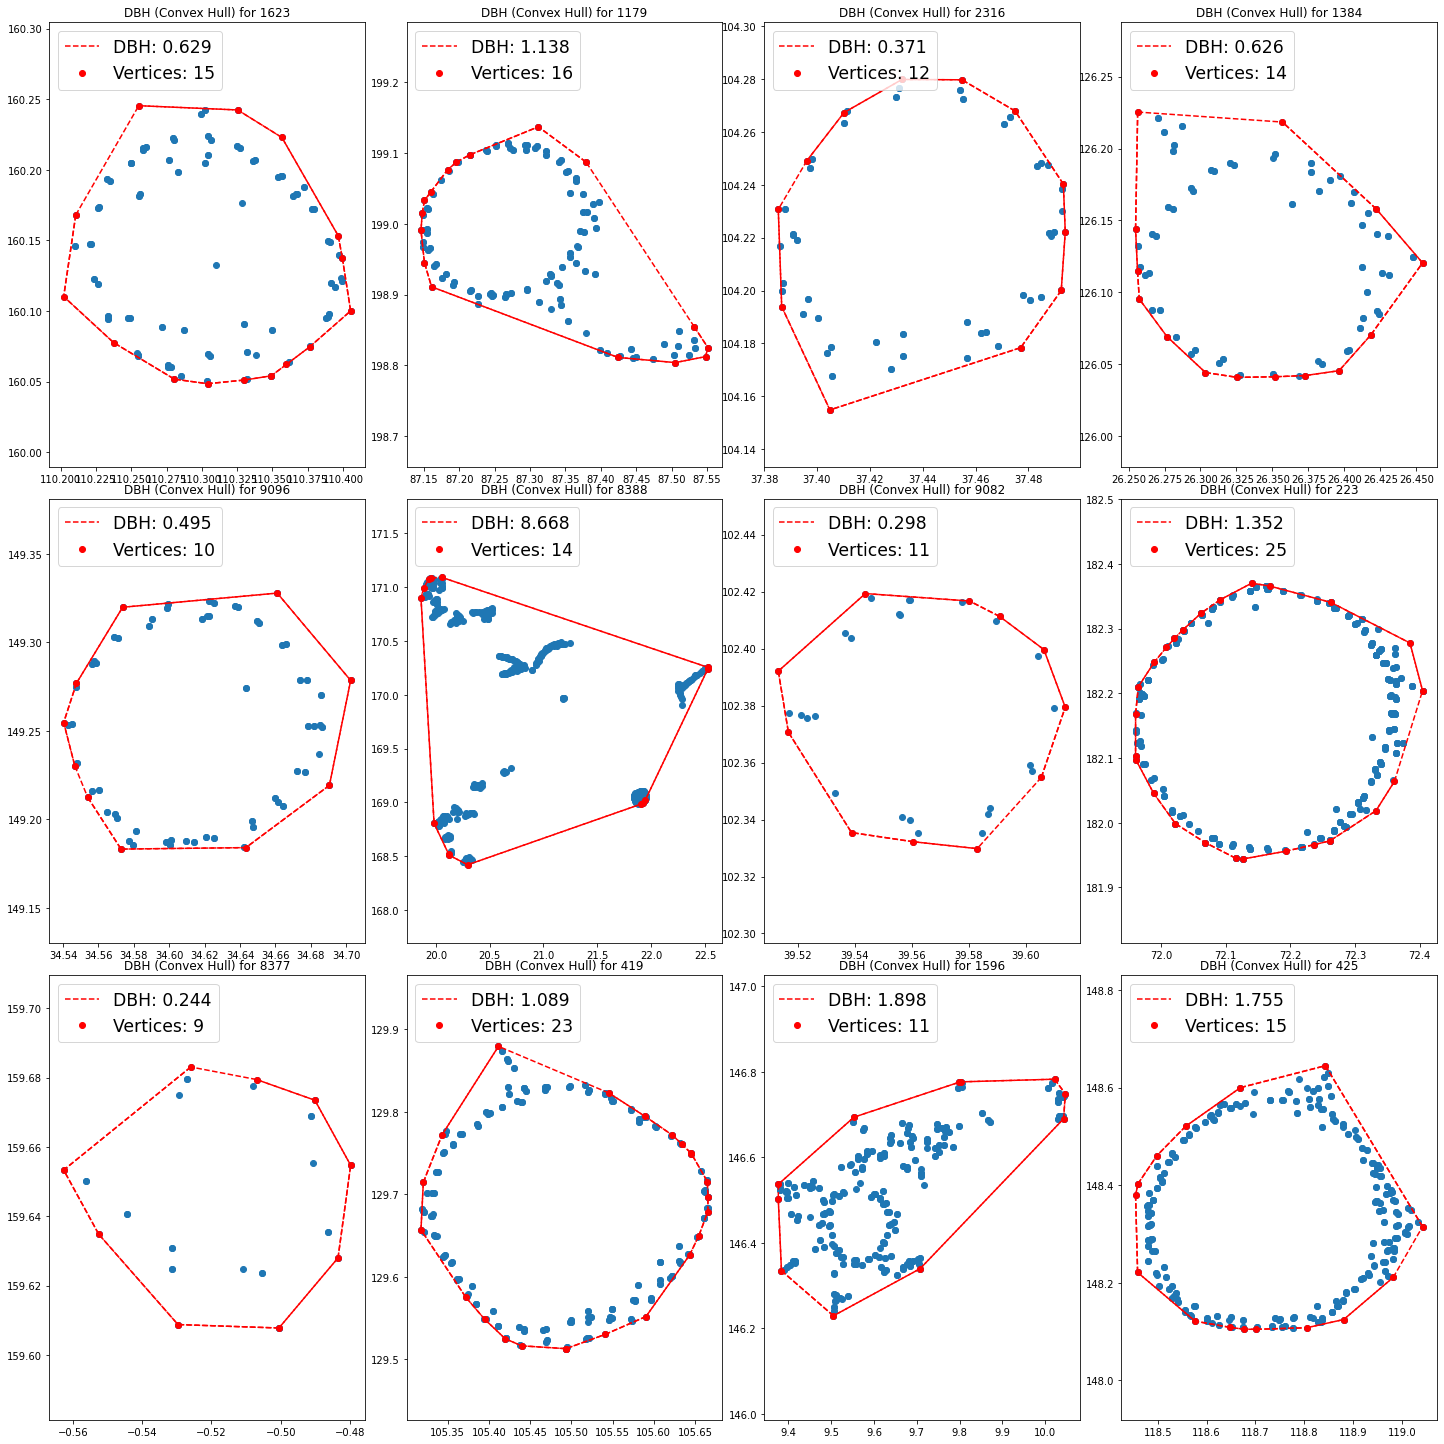

In [36]:
# calculate convex hull on all singlestemmed and plot first 12
df_dbh = calc_convexhull(singlestemmed, pts_path, False)
df_dbh_12 = calc_convexhull(singlestemmed[0:12], pts_path, True, ncols=4)

,TLS_ID,DBH_CV,DBH_Verts
0,8022,11.610755,13
1,8340,10.925968,19
2,2312,8.988729,11
3,8388,8.668195,14
4,8368,7.626973,14
5,8389,7.542673,12
6,8430,7.367218,10
7,8221,6.898664,9
8,8215,6.531892,13
9,8084,6.330659,15


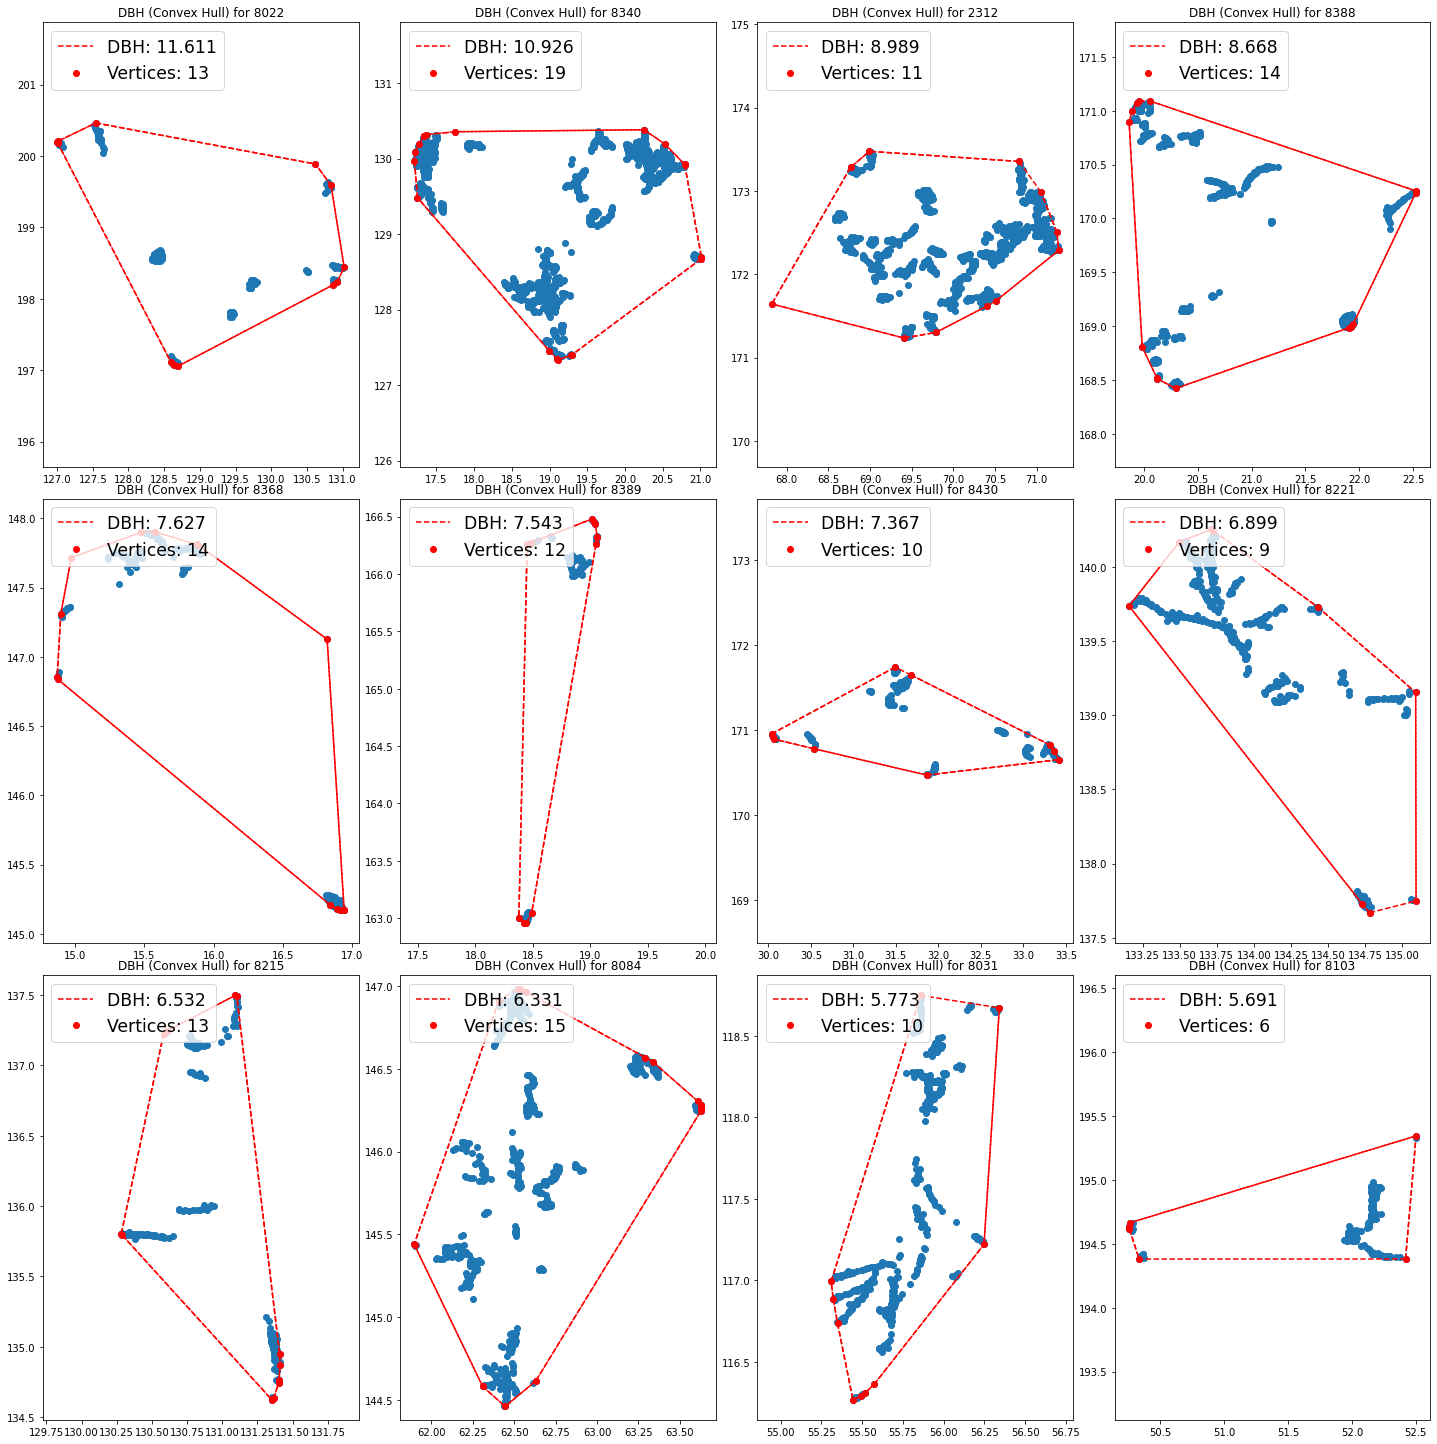

In [42]:
# appears that larger dbh values are coming from issues with pt clouds
# sort by dbh to highlight trees with issues 
df_dbh.sort_values('DBH_CV', ascending=False, inplace=True)

# make new list of just the top 12 'large dbh' trees and plot convex hull results
bigtrees = list(df_dbh.iloc[0:12, 0])
calc_convexhull(bigtrees, pts_path, True, ncols=4)

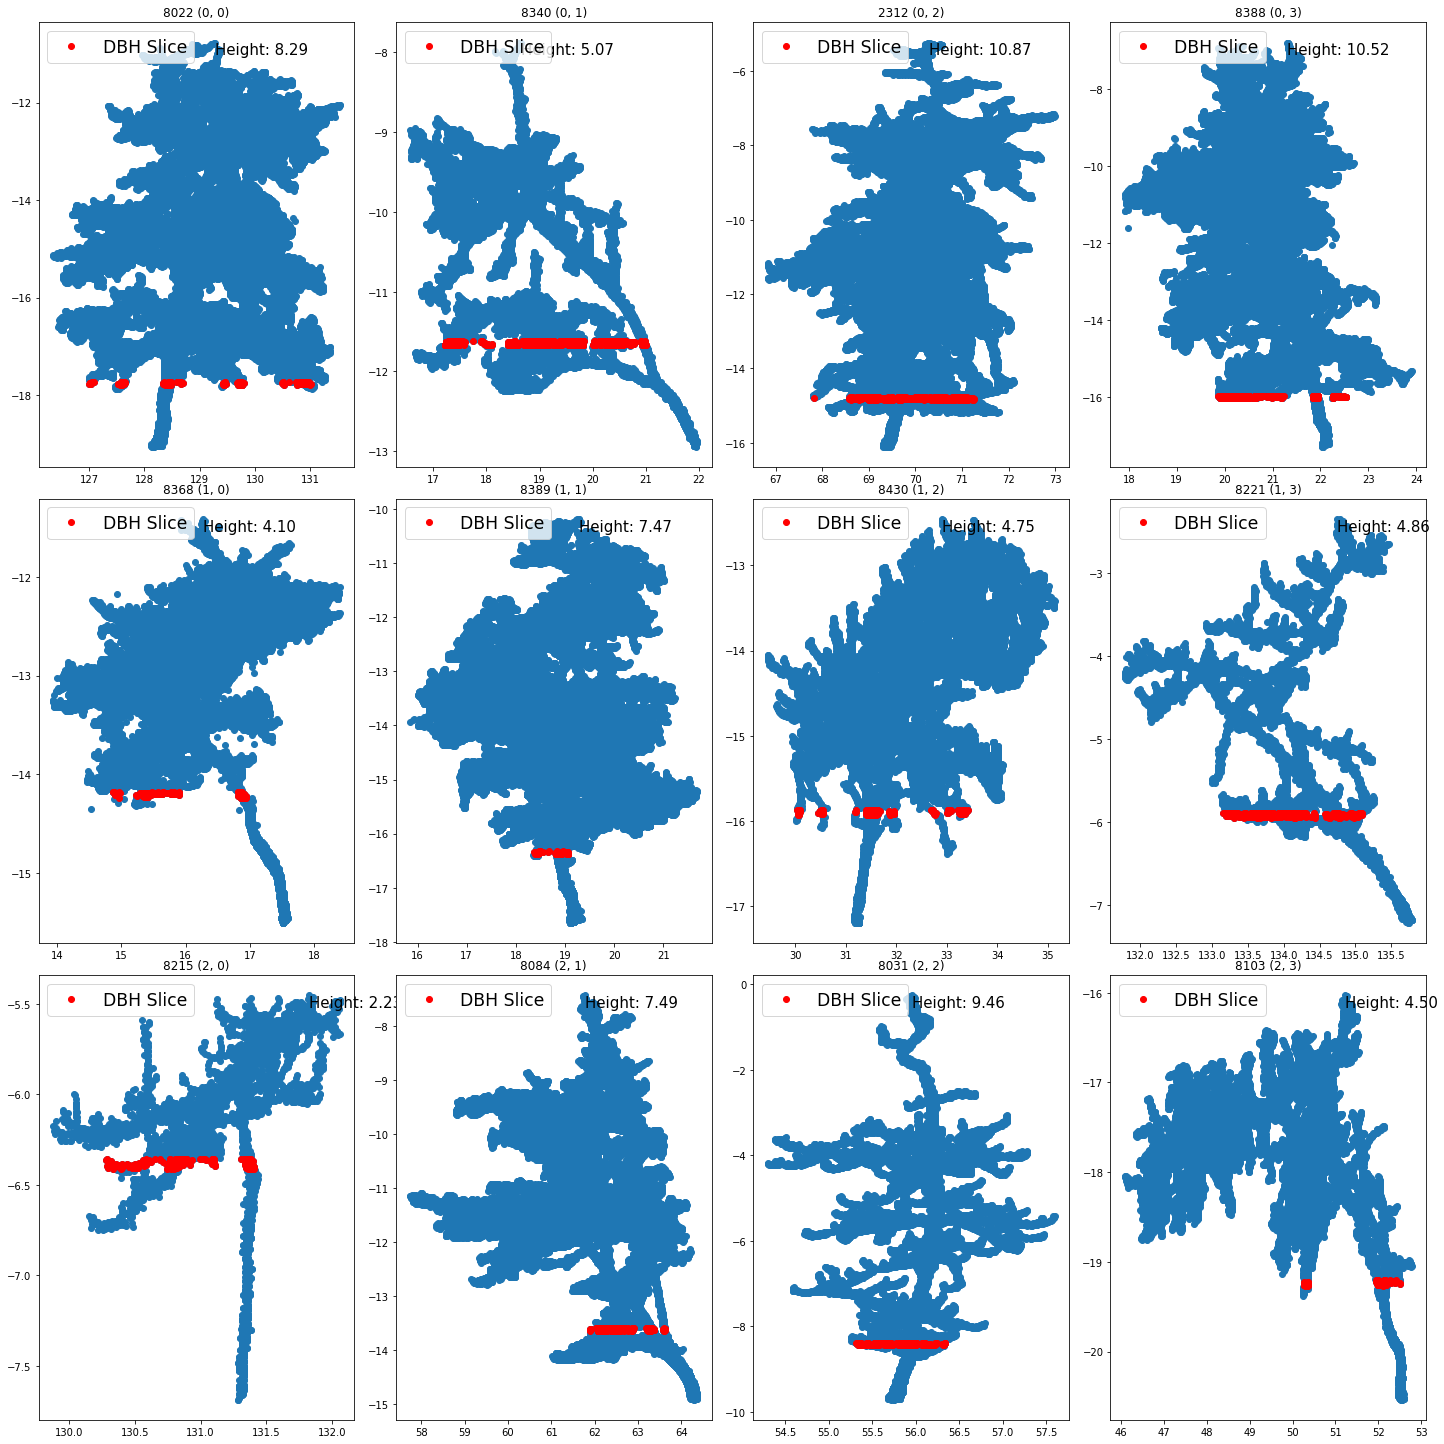

In [45]:
# plot these issue trees in 2d
plot2D(bigtrees, pts_path, ncols=4)

### Iterative DBH by Slice:

In [46]:
iterdbhout = iter_dbh(singlestemmed[0:32], pts_path, step=0.1, lim=3)

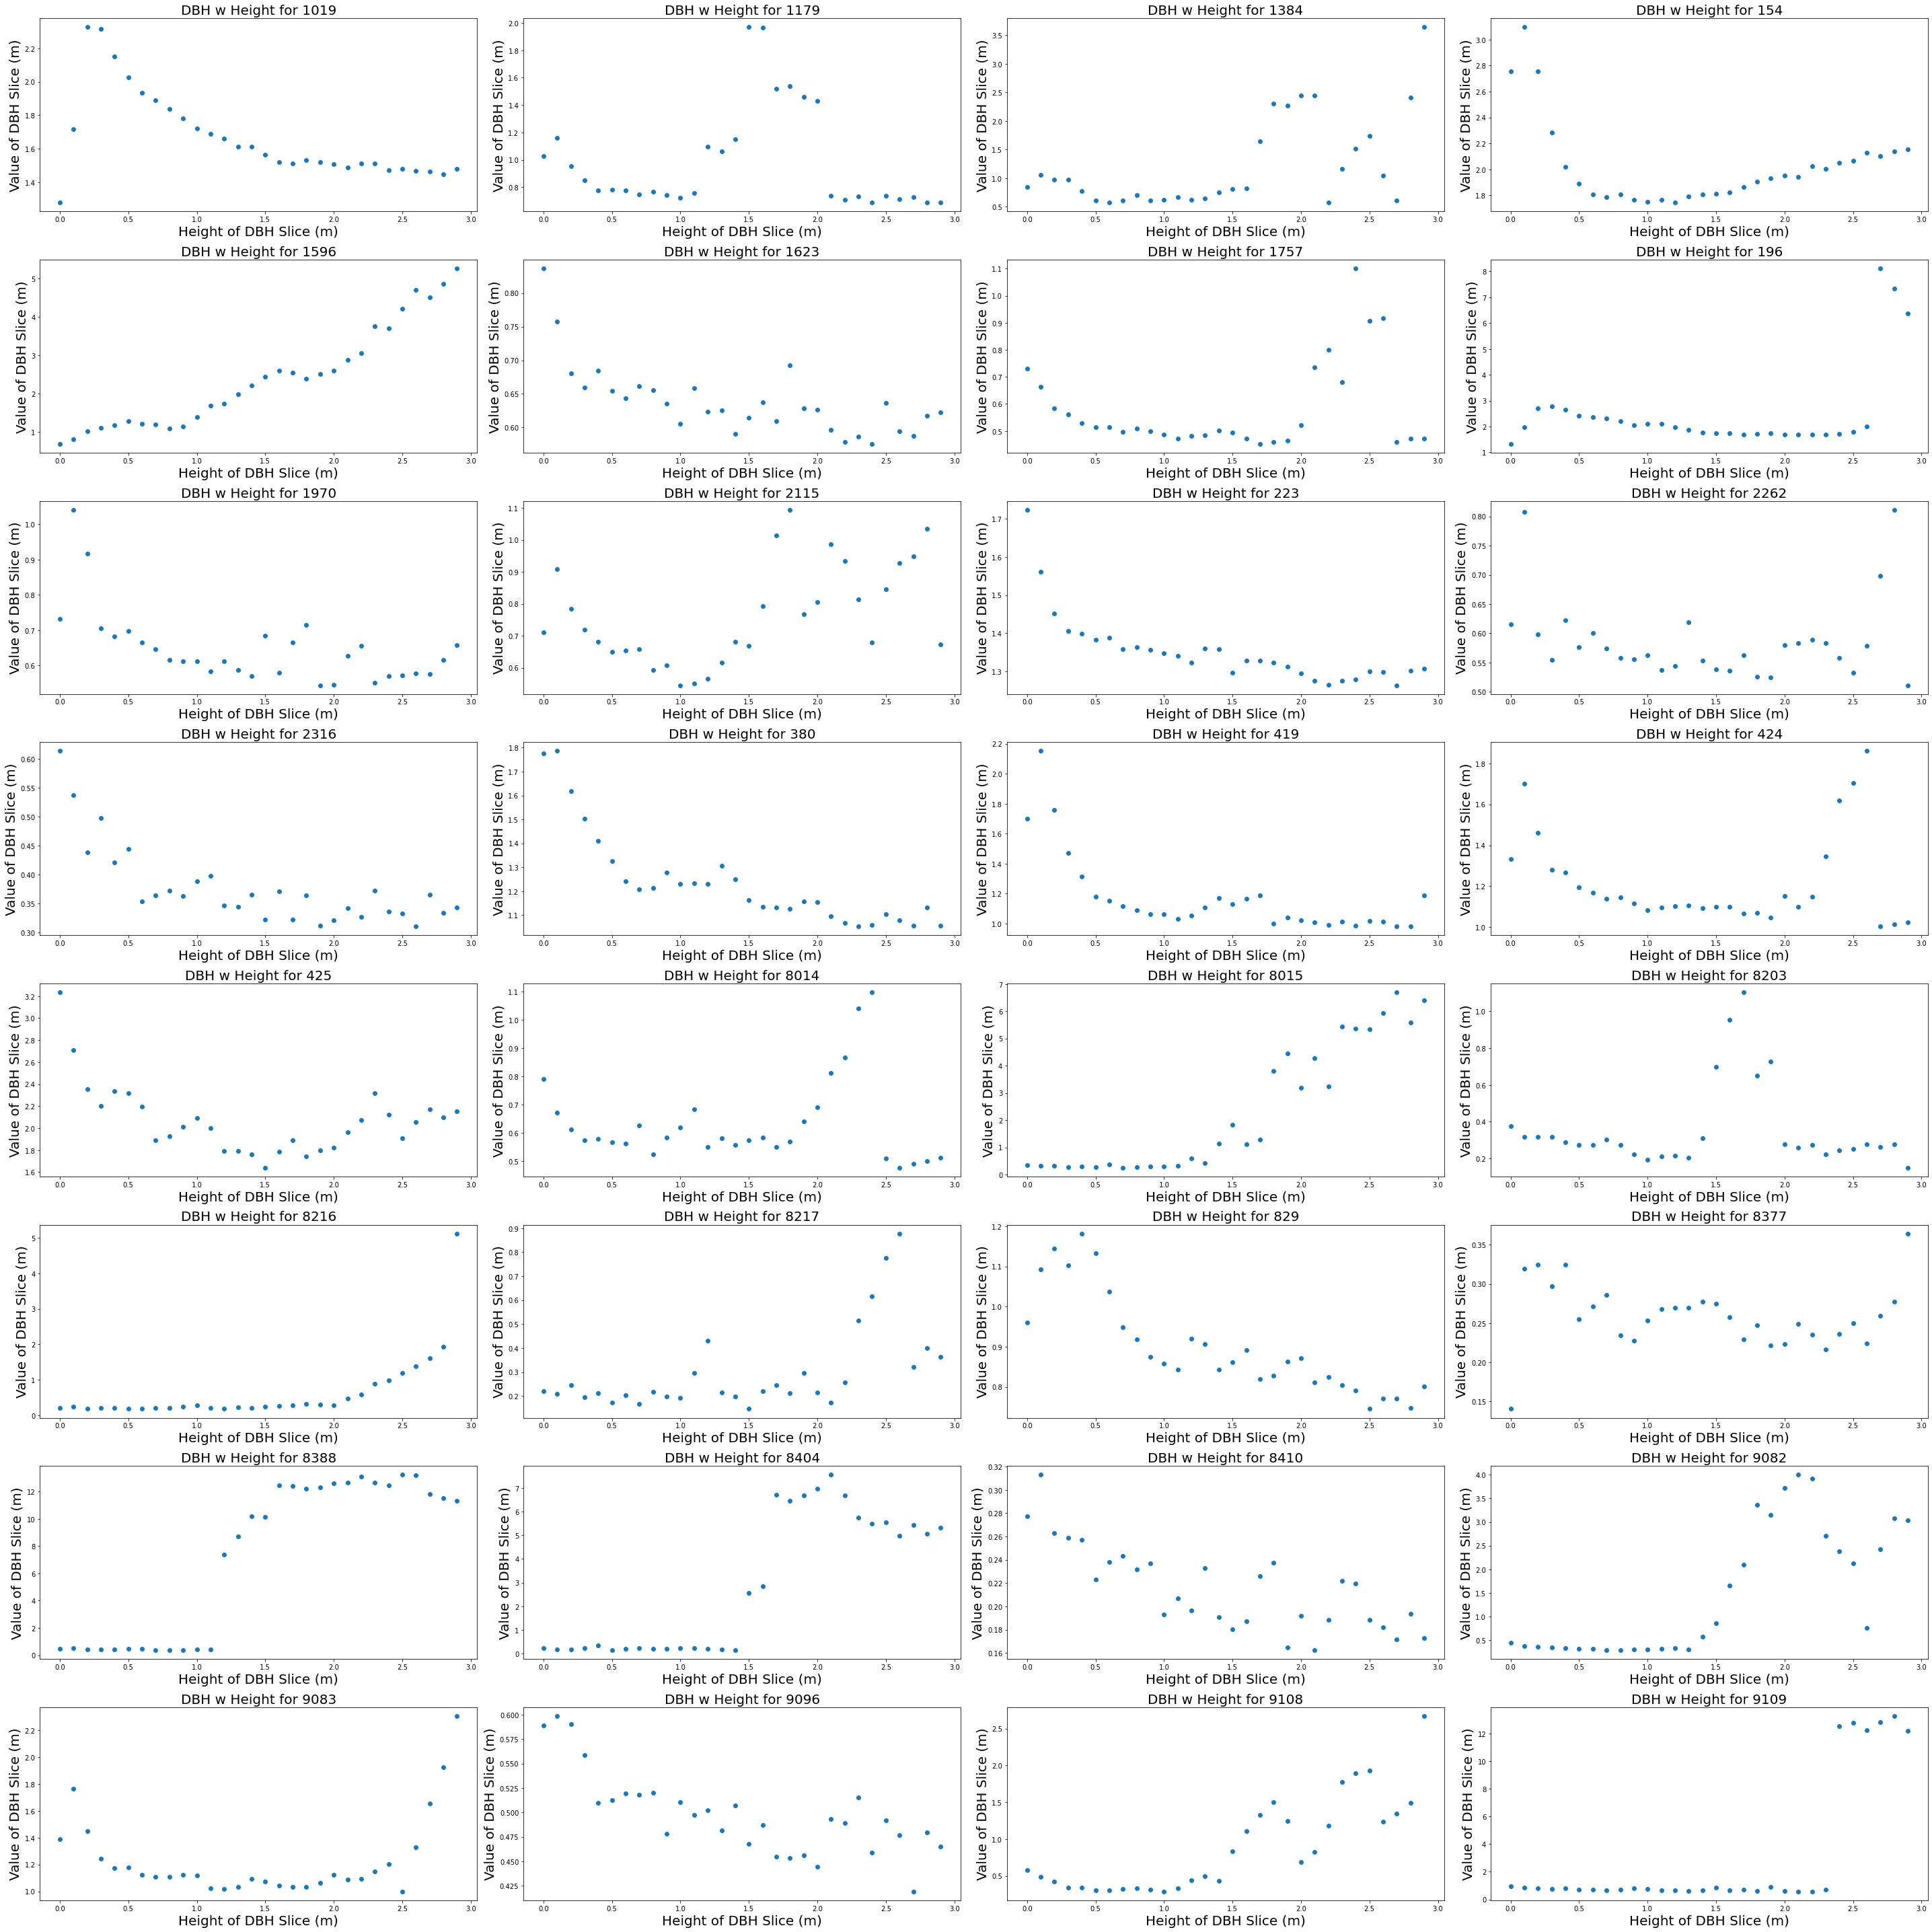

In [47]:
iterdbhout.sort_values('TLS_ID', inplace=True)

uniquetrees = iterdbhout.TLS_ID.unique()

# determine number of rows to plot figures
nplots = len(uniquetrees)
ncols = 4
if(nplots % ncols) != 0:
    nrows = int(nplots / ncols + 1)
else:
    nrows = int(nplots / ncols)

# initiate figure with nrows and ncols
fig, axs = plt.subplots(nrows, ncols, figsize=(40,40))

# initiate row, column, tree indices to 0 
rowind = 0
colind = 0
treeind = 0

for tree in uniquetrees:
    axs[rowind, colind].scatter(iterdbhout.loc[iterdbhout['TLS_ID'] == tree, 'Slice_Hgt'], iterdbhout.loc[iterdbhout['TLS_ID'] == tree, 'DBH_CV'])
    axs[rowind, colind].set_title(f'DBH w Height for {tree}', fontsize=20)
    axs[rowind, colind].set_xlabel('Height of DBH Slice (m)', fontsize=20)
    axs[rowind, colind].set_ylabel('Value of DBH Slice (m)', fontsize=20)
    
    fig.tight_layout()
    
    # increase tree index to get to next tree
    treeind += 1

    if (treeind % ncols) != 0:
        colind += 1
    else:
        rowind +=1 
        colind = 0



# DBH (Convex Hull) Results

### Calc Convex Hull on Single Stemmed (plot first 10)

### Predict DBH:

In [ ]:
treecsv = pd.read_csv(tree_csv_path)


treecsv = treecsv[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 'DBH_TLS_[m]',
                    'Hgt_pts_[m]', 'VerticalCrownProjectedArea_pts_[m2]', 'Vol_QSM_avg_[m3]',
                    'Vol_QSM_D0_25mm_avg_[m3]', 'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                    'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 'Vol_QSM_D200_500mm_avg_[m3]',
                    'Vol_QSM_D500_1000mm_avg_[m3]', 'Vol_QSM_D1000mm_avg_[m3]']]


treedata = pd.merge(df_dbh, treecsv, on ='TLS_ID')

treedata.head()

## Compare Convex Hull with "DBH_TLS[m]"

In [ ]:
# select only single stem trees from csv 
#ss_treedata = treecsv[treecsv[['TLS_ID']].apply(lambda x: x[-1].isdigit(), axis=1)]

smalltrees = treedata[treedata['DBH_CV']<4]

plt.figure(figsize=(10,7))
plt.scatter(smalltrees['DBH_CV'], smalltrees['DBH_TLS_[m]'])
plt.xlabel('DBH from Convex Hull', fontsize=20)
plt.ylabel('DBH from TLS', fontsize=20)


## Random Forest (Predicting DBH from QSMs)

In [ ]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Labels are the values we want to predict
labels = np.array(treedata['DBH_CV'])

# Remove the labels from the features
# axis 1 refers to the columns
features = treedata.drop(['TLS_ID','DBH_CV'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)



In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')



In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
#rf_results = pd.DataFrame(mape, predictions, test_labels)

rf_results = pd.DataFrame({'mape': mape, 'errors': errors,'predictions': predictions, 'test_labels': test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])

plt.figure(figsize=(10,7))
plt.scatter(rf_results['predictions'], rf_results['test_labels'])
plt.xlabel('Predictions (DBH)', fontsize=20)
plt.ylabel('Measured Values (DBH)', fontsize=20)


In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(rf_results['test_labels'], rf_results['errors'])
plt.xlabel('Measured Values (DBH)', fontsize=20)
plt.ylabel('Errors', fontsize=20)

In [ ]:
# merge rf results back with original dataset
#https://stackoverflow.com/questions/40729162/merging-results-from-model-predict-with-original-pandas-dataframe
# TODO: in final - re-run model on full dataset and split into training vs testing

df_out = pd.merge(treedata,rf_results[['mape', 'errors', 'predictions']],how = 'left',left_index = True, right_index = True)

#rf_results.shape
df_out.head(150)

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_out['DBH_Verts'], df_out['errors'])
plt.xlabel('DBH Verts', fontsize=20)
plt.ylabel('Errors', fontsize=20)

# Old Code: 

In [ ]:
# Functions from TLS_Inventory
# Some of the docstrings for functions added by Sabine to help make code easier to understand and modify later on.

# nearest neighbour needed for outlier removal
def nn(x,rad):
    """
    Function from TLS_Inventory.
    
    x: a numpy array, rad: radius to search for neighbors within
    
    My understanding - can either specify number of neighbors to return (in sklearn NearestNeighbors),
    or return all the neighbors and then filter to return only those within a specified distance radius
    """
    nbrs = NearestNeighbors(algorithm='auto', metric='euclidean').fit(x) 
    distances, indices = nbrs.radius_neighbors(radius=rad) #find all neighbours within this search radius
    
    #output explained: https://stackoverflow.com/questions/53886289/confused-with-the-output-of-sklearn-neighbors-nearestneighbors 
    return distances, indices


def load_pts(cloud,downsample=False,outliers=False): 
    """
    Function from TLS_Inventory that reads the point cloud data for single tree at a time and
    returns pandas dataframe with the points split into x, y, z coordinates. 
    
    cloud: point cloud from a single tree - note, point cloud data should be pre-processed and 
           split into individual trees prior to using this function.
    downsample (Optional): Default is False, meaning all the points are retained. If 
                           True, the point clouds are sampled to keep only fraction of points.
    outliers (Optional): Default is False, meaning outliers are retained. If True, 
    """
    # read the point cloud data for single tree and save as pandas df with columns for x, y, z coords
    dftemp=o3d.io.read_point_cloud(cloud)
    df=pd.DataFrame(data=np.asarray(dftemp.points),columns=['x', 'y', 'z']) #access the points
    
    # Optional downsampling
    if downsample:
        df=df.sample(frac=0.1) # keep 10pct of points
    
    # Optional outlier removal 
    if outliers: #remove outliers
        xy=df.iloc[:,0:2].values # takes ALL rows, first and second column - x and y - and .values converts to numpy array
        dist, indi = nn(xy,0.5) # get nearest neighbors within search radius of 0.5
        cnt=[len(i) for i in indi] # count the kNN within the search radius
        cnt = pd.DataFrame({'count':cnt})
        
        # set threshold for the number of neighbors we want to keep 
        threshold=df.shape[0]*0.0001 #1 neighbor for every 10 000 pts
        
        removed=sum(np.array(cnt)<threshold)
        df=df[np.array(cnt)>=threshold]
        print("Removed %i outliers using kNN threshold %.2f" % (removed[0], threshold-1))
    
    return df #return pandas dataframe 

def plot_polygon(x,y,polygon,treename):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    margin = .3 #plotbounds margin
    x_min, y_min, x_max, y_max = polygon.bounds
    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    plt.axis('equal')
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.plot(x, y, 'ro', label='data', mew=1,alpha=0.3,zorder=1)
    patch = PolygonPatch(polygon, fc='#999999',ec='#000000', fill=True,zorder=2,label='Concave hull',alpha=0.5,lw=2)
    ax.add_patch(patch)
    plt.legend(loc='best',labelspacing=0.1 )
    plt.grid()
    plt.title("Vertical crown projection of %s" %treename)
#     plt.show()
    if not os.path.exists('plot/VCP/'):
        os.makedirs('plot/VCP')
    plt.savefig('plot/VCP/VCP_'+str(treename)+'.png')
    plt.close()
    
def alpha_shape(x, y, alpha,treename,plotsavefig=False):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    points=list(zip(x,y))
    points=[geometry.Point(point) for point in points]
    total_area = 0
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha: #the larger alpha, the fewer triangles will be included
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    poly=cascaded_union(triangles)
    if plotsavefig:
        #print('df', df.shape)
        #print(df.head)
        #print(poly)
        plot_polygon(df['x'],df['y'],poly,treename)
    return poly.area, poly.length, poly, edge_points

def calc_hgt(z): #z is pandasdf column of z
    hgt=z.max() - z.min()
    return hgt

def calc_R(x,y, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)
        
def f(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()
    
def plot_dbh(x,y, xc, yc, R,polygon,df,treename,qsm_path, QSM=True):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    x_min, y_min, x_max, y_max = polygon.bounds
    plt.axis('equal')
    theta_fit = np.linspace(-pi, pi, 180)
    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    plt.plot(x_fit, y_fit, 'b-' , label="fitted circle", lw=2,zorder=5)
    plt.plot([xc], [yc], 'bD', mec='y', mew=1)
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    if QSM:
        iter_list = glob.glob("%s%s-*" % (qsm_path,treename))
        print('list of qsm: ', iter_list)
        lab_legend=0
        for qsmfile in iter_list:
            data = sio.loadmat(qsmfile)
            i = 0
            while sum(data['Len'][0:i+1]) < 1.3:
                i = i+1;
            offset_of_dbhHeight=1.3-sum(data['Len'][0:i])
            #need to correct the xy location for plotting since it's a cylinder spanning some length
            xqsm = data['Sta'][i][0]+offset_of_dbhHeight*data['Axe'][i][0]
            yqsm = data['Sta'][i][1]+offset_of_dbhHeight*data['Axe'][i][1]
            Rqsm = data['Rad'][i][0]
            df_qsm = df[(df['z'] > data['Sta'][i][2])  & (df['z'] < data['Sta'][i][2]+data['Len'][i][0])]
            if (lab_legend == 0): #only need legend once
#                 plt.plot(df_qsm['x'], df_qsm['y'], 'go', label='Points construction QSM', mew=1,alpha=0.2,zorder=-1)
                xqsm_fit = xqsm + Rqsm*np.cos(theta_fit)
                yqsm_fit = yqsm + Rqsm*np.sin(theta_fit)
                plt.plot(xqsm_fit, yqsm_fit, 'g-' , label="QSM cylinder", lw=2,zorder=3)  
                lab_legend=1
            else:
#                plt.plot(df_qsm['x'], df_qsm['y'], 'go', mew=1,alpha=0.3) #don't need to plot these points 10 times, might be "problem" if cylinder close to 1.3m length
                xqsm_fit = xqsm + Rqsm*np.cos(theta_fit)
                yqsm_fit = yqsm + Rqsm*np.sin(theta_fit)
                plt.plot(xqsm_fit, yqsm_fit, 'g-', lw=2,zorder=2)  
    # plot data
    #plt.plot([xqsm], [yqsm], 'gD', mec='y', mew=1)
    plt.plot(x, y, 'ro', label='Points circle fit', mew=1,alpha=0.3,zorder=4)
    patch = PolygonPatch(polygon, fc='#999999',ec='#000000', fill=True,label='Concave hull',zorder=2,alpha=0.7)
    ax.add_patch(patch)
    plt.legend(loc='best',labelspacing=0.1 )
    plt.grid()
    plt.title("DBH cross section of %s" %treename)
    #if not os.path.exists('plot/DBH/'):
        #os.makedirs('plot/DBH')
    #plt.savefig('plot/DBH/DBH_'+str(treename)+'.png')
    plt.show()
    plt.close()



def averageQSM(treename,path_to_qsm): #this will calculate the average of multiple QSM iterations of treename
    iter_list = glob.glob("%s%s-*" % (path_to_qsm,treename))
    if (len(iter_list) != 10):
        sys.exit("There are no 10 QSMs for tree %s" %treename)
    vol = []
    dbh = []
    x_qsm = []
    y_qsm = []
    vol0_25 = []
    vol25_50 = []
    vol50_75 = []
    vol75_100 = []
    vol100_200 = []
    vol200_500 = []
    vol500_1000 = []
    vol1000 = []
    #Loop over iterations of QSM
    for file in iter_list:
#         print("opening %s" %file)
        data = sio.loadmat(file)
        vol.append(data['TreeData'][0][0]/1000) #convert to m3
        dbh.append(data['TreeData'][9][0]/100) #convert to m
        i=0
        while sum(data['Len'][0:i+1]) < 1.3:
            i = i+1;
        if (sum(data['Len'][0:i])==0):
            offset_of_dbhHeight=1.3-sum(data['Len'][0:i])
        else:
            offset_of_dbhHeight=1.3-sum(data['Len'][0:i][0])
        #need to correct the xy location for plotting since it's a cylinder spanning some length
        x_qsm.append(data['Sta'][i][0]+offset_of_dbhHeight*data['Axe'][i][0])
        y_qsm.append(data['Sta'][i][1]+offset_of_dbhHeight*data['Axe'][i][1])
        #calculate vols per diam class
        #divide in classes
        tmp_vol0_25 = []
        tmp_vol25_50 = []
        tmp_vol50_75 = []
        tmp_vol75_100 = []
        tmp_vol100_200 = []
        tmp_vol200_500 = []
        tmp_vol500_1000 = []
        tmp_vol1000 = []
        for i in range(0,len(data['Rad'])):
            if (data['Rad'][i]<=0.0125):
                tmp_vol0_25.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.025):
                tmp_vol25_50.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.0375):
                tmp_vol50_75.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.05):
                tmp_vol75_100.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.1):
                tmp_vol100_200.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.25):
                tmp_vol200_500.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            elif (data['Rad'][i]<=0.5):
                tmp_vol500_1000.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
            else:
                tmp_vol1000.append(pi*data['Len'][i][0]*data['Rad'][i][0]**2) #this is m3
        # sum up per class
        vol0_25.append(sum(tmp_vol0_25))
        vol25_50.append(sum(tmp_vol25_50))
        vol50_75.append(sum(tmp_vol50_75))
        vol75_100.append(sum(tmp_vol75_100))
        vol100_200.append(sum(tmp_vol100_200))
        vol200_500.append(sum(tmp_vol200_500))
        vol500_1000.append(sum(tmp_vol500_1000))
        vol1000.append(sum(tmp_vol1000))
    #Calculate avg and sd of QSM
    vol_avg = np.mean(vol,axis=0)
    vol_sd = np.std(vol, ddof=1,axis=0) #the same as excell STDEV
    dbh_avg = np.mean(dbh,axis=0)
    dbh_sd = np.std(dbh, ddof=1,axis=0) #the same as excell STDEV
    xqsm= np.mean(x_qsm,axis=0)
    yqsm= np.mean(y_qsm,axis=0)
    vol0_25_avg = np.mean(vol0_25,axis=0)
    vol0_25_sd = np.std(vol0_25, ddof=1,axis=0) #the same as excell STDEV
    vol25_50_avg = np.mean(vol25_50,axis=0)
    vol25_50_sd = np.std(vol25_50, ddof=1,axis=0) #the same as excell STDEV
    vol50_75_avg = np.mean(vol50_75,axis=0)
    vol50_75_sd = np.std(vol50_75, ddof=1,axis=0) #the same as excell STDEV
    vol75_100_avg = np.mean(vol75_100,axis=0)
    vol75_100_sd = np.std(vol75_100, ddof=1,axis=0) #the same as excell STDEV
    vol100_200_avg = np.mean(vol100_200,axis=0)
    vol100_200_sd = np.std(vol100_200, ddof=1,axis=0) #the same as excell STDEV
    vol200_500_avg = np.mean(vol200_500,axis=0)
    vol200_500_sd = np.std(vol200_500, ddof=1,axis=0) #the same as excell STDEV
    vol500_1000_avg = np.mean(vol500_1000,axis=0)
    vol500_1000_sd = np.std(vol500_1000, ddof=1,axis=0) #the same as excell STDEV
    vol1000_avg = np.mean(vol1000,axis=0)
    vol1000_sd = np.std(vol1000, ddof=1,axis=0) #the same as excell STDEV

    return xqsm, yqsm,vol_avg, vol_sd, dbh_avg, dbh_sd,vol0_25_avg,vol0_25_sd,\
    vol25_50_avg,vol25_50_sd,vol50_75_avg,vol50_75_sd,vol75_100_avg,vol75_100_sd,\
    vol100_200_avg,vol100_200_sd,vol200_500_avg,vol200_500_sd,vol500_1000_avg,vol500_1000_sd,\
    vol1000_avg,vol1000_sd

In [ ]:
def calc_dbh(trees, ptspath, plot=True, nnthresh=0.05):
    if plot:
        fig, axs = formatplots(trees, ncols=4)
        rowind = colind = treeind = 0

    for tree in trees:
        # Get treeID
        tree, tree_num = construct_treeid(tree, ptspath)

        #get DBH from full cloud to preserve max number of hits on stem slice
        pts = load_pts(tree,False,False)
        
        if pts['z'].max() - pts['z'].min() > 1.3: #check if tree is at least 1.3m height
            #get slice 1.27 - 1.33 m - limits according to Tansey et al 2009; Calders et al. 2015
            df_dbh = pts[(pts['z'] > pts['z'].min() + 1.27) & (pts['z'] < pts['z'].min() + 1.33)]
            
            #filter outliers of DBH slice:
            #take xy data only
            xy=df_dbh.iloc[:,0:2].values #takes ALL rows, first and second column - x and y - and .values converts to numpy array
            dist, indi = nn(xy,nnthresh)
            cnt=[len(i) for i in indi] #count the kNN within the search radius
            cnt = pd.DataFrame({'count':cnt})
            threshold=2
            removed=sum(np.array(cnt)<threshold)
            df_dbh_out=df_dbh[np.array(cnt)>=threshold]
            print("Removed %i outliers from DBH slice using kNN threshold %.2f" % (removed[0], threshold-1))
            ###
            x = df_dbh_out['x']
            y = df_dbh_out['y']
            #calc DBH ; from https://scipy-cookbook.readthedocs.io/items/Least_Squares_Circle.html
            #Optimize.leastsq is the most efficient method ; algebraic does not work well when not full circle is covered
                # coordinates of the barycenter
            x_m = x.mean() #as first estimte of center
            y_m = y.mean()
            center_estimate = x_m, y_m
            center, ier = optimize.leastsq(f, center_estimate, args=(x,y)) #f is the function you want to optimise/minimise
            xc, yc = center
            Ri       = calc_R(x, y, *center)
            R        = Ri.mean() #this is the radius
            residu   = np.sum((Ri - R)**2)/len(Ri) #avg residual between pts and fitted circle
            #outer hull:
            ##slightly larger alpha here, want to resolve some detail in dbh slice
            Tarea, Lshape, concave_hull, edge_points = alpha_shape(x,y,5,tree,False) 

        else:
            xc = yc = R = residu = 'NA'
        
        if plot:
            theta_fit = np.linspace(-pi, pi, 180)
            x_fit = xc + R*np.cos(theta_fit)
            y_fit = yc + R*np.sin(theta_fit)
            
            axs[rowind, colind].axis('equal')
            axs[rowind, colind].plot(x_fit, y_fit, 'b-' , label="fitted circle", lw=2,zorder=5)
            axs[rowind, colind].plot([xc], [yc], 'bD', mec='y', mew=1)

            
            iter_list = glob.glob("%s*%s-*" % (qsm_path,tree_num))
            lab_legend=0
            for qsmfile in iter_list:
                data = sio.loadmat(qsmfile)
                i = 0
                while sum(data['Len'][0:i+1]) < 1.3:
                    i = i+1;
                offset_of_dbhHeight=1.3-sum(data['Len'][0:i])

                #need to correct the xy location for plotting since it's a cylinder spanning some length
                xqsm = data['Sta'][i][0]+offset_of_dbhHeight*data['Axe'][i][0]
                yqsm = data['Sta'][i][1]+offset_of_dbhHeight*data['Axe'][i][1]
                Rqsm = data['Rad'][i][0]
                df_qsm = pts[(pts['z'] > data['Sta'][i][2])  & (pts['z'] < data['Sta'][i][2]+data['Len'][i][0])]
                if (lab_legend == 0): #only need legend once
    #                 plt.plot(df_qsm['x'], df_qsm['y'], 'go', label='Points construction QSM', mew=1,alpha=0.2,zorder=-1)
                    xqsm_fit = xqsm + Rqsm*np.cos(theta_fit)
                    yqsm_fit = yqsm + Rqsm*np.sin(theta_fit)
                    axs[rowind, colind].plot(xqsm_fit, yqsm_fit, 'g-' , label="QSM cylinder", lw=2,zorder=3)  
                    lab_legend=1
                else:
    #               plt.plot(df_qsm['x'], df_qsm['y'], 'go', mew=1,alpha=0.3) #don't need to plot these points 10 times, might be "problem" if cylinder close to 1.3m length
                    xqsm_fit = xqsm + Rqsm*np.cos(theta_fit)
                    yqsm_fit = yqsm + Rqsm*np.sin(theta_fit)
                    axs[rowind, colind].plot(xqsm_fit, yqsm_fit, 'g-', lw=2,zorder=2)  

            # plot data
            axs[rowind, colind].plot([xqsm], [yqsm], 'gD', mec='y', mew=1)
            
            # plot full xy with outliers
            axs[rowind, colind].plot(df_dbh['x'], df_dbh['y'], 'go', label='with outliers', mew=1,alpha=0.3,zorder=4)
            
            axs[rowind, colind].plot(x, y, 'ro', label='Points circle fit', mew=1,alpha=0.3,zorder=4)
            patch = PolygonPatch(concave_hull, fc='#999999',ec='#000000', fill=True,label='Concave hull',zorder=2,alpha=0.7)
            axs[rowind, colind].add_patch(patch)
            axs[rowind, colind].legend(loc='best',labelspacing=0.1 )

            axs[rowind, colind].legend(fontsize='xx-large')
            fig.tight_layout()

            # increase tree index to get to next tree
            treeind += 1

            if (treeind % ncols) != 0:
                colind += 1
            else:
                rowind +=1 
                colind = 0
            
    return xc, yc, R, residu, Tarea, Lshape, concave_hull



In [ ]:
# compare to the calc dbh function with qsms and fitted circle
bigtreedbh = calc_dbh(bigtrees, pts_path, True)